# GE Health Hack

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [9]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import *
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2  #bringing in OpenCV libraries
import subprocess

In [5]:
def process_image(image):
       # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # Read in the image
    #print(image)
    #image = mpimg.imread(image)

    # Grab the x and y sizes and make two copies of the image
    # With one copy we'll extract only the pixels that meet our selection,
    # then we'll paint those pixels red in the original image to see our selection 
    # overlaid on the original.
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select= np.copy(image)
    line_image = np.copy(image)

    # Define our color criteria
    red_threshold = 0
    green_threshold = 0
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Define a triangle region of interest (Note: if you run this code, 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing
    # you'll find these are not sensible values!!
    # But you'll get a chance to play with them soon in a quiz ;)
    left_bottom = [0, 539]
    right_bottom = [900, 300]
    apex = [400, 0]

    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Mask pixels below the threshold
    color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                        (image[:,:,1] < rgb_threshold[1]) | \
                        (image[:,:,2] < rgb_threshold[2])

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))
    # Mask color selection
    color_select[color_thresholds] = [0,0,0]
    # Find where image is both colored right and in the region
    line_image[~color_thresholds & region_thresholds] = [255,0,0]

    # Display our two output images
    plt.imshow(color_select)
    plt.imshow(line_image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    plt.imshow(gray, cmap='gray')
    
    
    # Read in and grayscale the image
    #image = mpimg.imread('exit-ramp.jpg')
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/(180)
    threshold = 1
    min_line_length = 10
    max_line_gap = 1
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    plt.imshow(combo)
    return combo

In [21]:
def process_image_withboundingbox(image,left=0, top=0 , right=255 , bottom=255):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # Read in the image
    #print(image)
    #image = mpimg.imread(image)

    # Grab the x and y sizes and make two copies of the image
    # With one copy we'll extract only the pixels that meet our selection,
    # then we'll paint those pixels red in the original image to see our selection 
    # overlaid on the original.
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select= np.copy(image)
    line_image = np.copy(image)

    # Define our color criteria
    red_threshold = 0
    green_threshold = 0
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Define a triangle region of interest (Note: if you run this code, 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing
    # you'll find these are not sensible values!!
    # But you'll get a chance to play with them soon in a quiz ;)
    left_bottom = [left,bottom]
    right_bottom = [right, bottom]
    left_top = [left, top]
    right_top=[right, top]
    

    # Mask pixels below the threshold
    color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                        (image[:,:,1] < rgb_threshold[1]) | \
                        (image[:,:,2] < rgb_threshold[2])

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > top) & (YY < bottom) &  (XX >left) & (XX <right)
                        
                
    # Mask color selection
    color_select[color_thresholds] = [0,0,0]
    # Find where image is both colored right and in the region
    line_image[~color_thresholds & ~region_thresholds] = [0,0,0]

    # Display our two output images
    plt.imshow(color_select)
    plt.imshow(line_image)
    #return line_image
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    plt.imshow(gray, cmap='gray')
    
    
    # Read in and grayscale the image
    #image = mpimg.imread('exit-ramp.jpg')
    line_gray = cv2.cvtColor(line_image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    line_blur_gray = cv2.GaussianBlur(line_gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 150
    line_edges = cv2.Canny(line_blur_gray, low_threshold, high_threshold)

    
    
    # Read in and grayscale the image
    #image = mpimg.imread('exit-ramp.jpg')
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/(180)
    threshold = 1
    min_line_length = 5
    max_line_gap = 1
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(line_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
   
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    plt.imshow(combo)
    return combo
    

[MoviePy] >>>> Building video icu-videos/training0-processed.mp4
[MoviePy] Writing video icu-videos/training0-processed.mp4







  0%|          | 0/350 [00:00<?, ?it/s]




  0%|          | 1/350 [00:02<11:50,  2.04s/it]




  1%|          | 2/350 [00:04<11:55,  2.06s/it]




  1%|          | 3/350 [00:06<12:04,  2.09s/it]




  1%|          | 4/350 [00:08<12:03,  2.09s/it]




  1%|▏         | 5/350 [00:10<12:01,  2.09s/it]




  2%|▏         | 6/350 [00:12<12:03,  2.10s/it]




  2%|▏         | 7/350 [00:14<11:49,  2.07s/it]




  2%|▏         | 8/350 [00:16<11:45,  2.06s/it]




  3%|▎         | 9/350 [00:18<11:36,  2.04s/it]




  3%|▎         | 10/350 [00:20<11:33,  2.04s/it]




  3%|▎         | 11/350 [00:22<11:39,  2.06s/it]




  3%|▎         | 12/350 [00:24<11:48,  2.10s/it]




  4%|▎         | 13/350 [00:27<11:50,  2.11s/it]




  4%|▍         | 14/350 [00:29<11:49,  2.11s/it]




  4%|▍         | 15/350 [00:31<11:36,  2.08s/it]




  5%|▍         | 16/350 [00:33<11:26,  2.06s/it]




  5%|▍         | 17/350 [00:35<11:18,  2.04s/it]




  5%|▌         | 18/350 [00:37<11:28,  2.07s/it]




  5%|▌

[MoviePy] Done.
[MoviePy] >>>> Video ready: icu-videos/training0-processed.mp4 



CPU times: user 6.83 s, sys: 6.1 s, total: 12.9 s
Wall time: 11min 46s


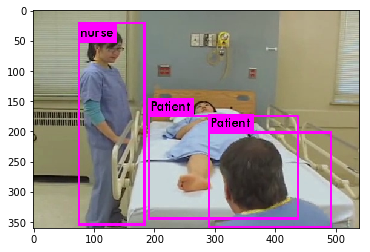

In [267]:
white_output = 'icu-videos/training0-processed.mp4'
clip1 = VideoFileClip("icu-videos/training0.mp4")
white_clip = clip1.fl_image(rcnn_apply_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [7]:
def rcnn_apply_image_withboundingbox(image):
    cv2.imwrite( "/media/ashutosh/unix-extra1/udacity/yolo/darknet/test.jpg", image );
    p = subprocess.Popen(["./darknet", 'detect', 'cfg/yolo.cfg', '../yolo.weights', 'test.jpg', '-thresh', '0.2'], cwd='/media/ashutosh/unix-extra1/udacity/yolo/darknet')
    p.wait()
    img_processed=cv2.imread('/media/ashutosh/unix-extra1/udacity/yolo/darknet/predictions.png')
    plt.imshow(img_processed)
    lines = []
    with open("/media/ashutosh/unix-extra1/udacity/yolo/darknet/rectangles.txt") as f:
        for line in f:
            lines.append(line)
    #print (lines) 
    coordinates=lines[0].split(' ' )
    #print (coordinates)
    return process_image_withboundingbox(image ,int(coordinates[0]),int(coordinates[1]),int(coordinates[2]),int(coordinates[3].strip('\n')))

In [261]:
def rcnn_apply_image(image):
    cv2.imwrite( "/media/ashutosh/unix-extra1/udacity/yolo/darknet/test.jpg", image );
    p = subprocess.Popen(["./darknet", 'detect', 'cfg/yolo.cfg', '../yolo.weights', 'test.jpg', '-thresh', '0.2'], cwd='/media/ashutosh/unix-extra1/udacity/yolo/darknet')
    p.wait()
    img_processed=cv2.imread('/media/ashutosh/unix-extra1/udacity/yolo/darknet/predictions.png')
    plt.imshow(img_processed)
    return img_processed

['97 88 270 173\n']
['97', '88', '270', '173\n']


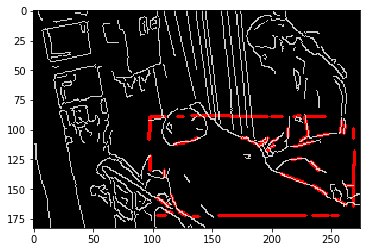




 40%|███▉      | 139/350 [00:21<00:32,  6.47it/s]

In [264]:
img_test=cv2.imread('cnn-images/nurse-patient.jpg')
processed_image=rcnn_apply_image_withboundingbox(img_test)
plt.imshow(processed_image)
image1 = cv2.imread('cnn-images/nurse-patient.jpg',1)
image2 = cv2.imread("/media/ashutosh/unix-extra1/udacity/yolo/darknet/predictions.png",1)
image3 = image1 -image2


In [192]:
plt.imshow(image1)
plt.imshow(process_image_withboundingbox(image1 ,97, 88, 270 ,173))

(183, 275, 3)

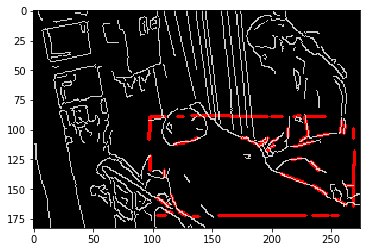

In [242]:
plt.imshow(image1)
plt.imshow(process_image_withboundingbox(image1 ,97, 88, 270 ,173))

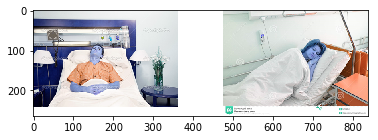

In [28]:
plt.imshow(cv2.imread('cnn-images/bed-lying.png'))

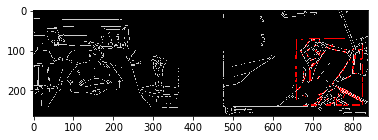

In [27]:
img_test=cv2.imread('cnn-images/bed-lying.png')
processed_image=rcnn_apply_image_withboundingbox(img_test)
plt.imshow(processed_image)

[MoviePy] >>>> Building video icu-videos/training8-processed.mp4
[MoviePy] Writing video icu-videos/training8-processed.mp4



  2%|▏         | 7/462 [00:22<23:59,  3.16s/it]

KeyboardInterrupt: 

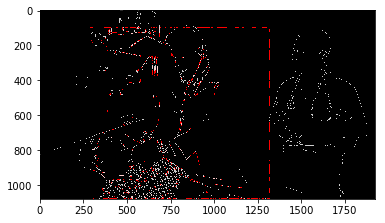

In [26]:
white_output = 'icu-videos/training8-processed.mp4'
clip1 = VideoFileClip("icu-videos/training8.mp4")
white_clip = clip1.fl_image(rcnn_apply_image_withboundingbox) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video icu-videos/training7-processed.mp4
[MoviePy] Writing video icu-videos/training7-processed.mp4



100%|██████████| 337/337 [12:39<00:00,  2.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: icu-videos/training7-processed.mp4 

CPU times: user 7min 42s, sys: 15.2 s, total: 7min 57s
Wall time: 12min 39s


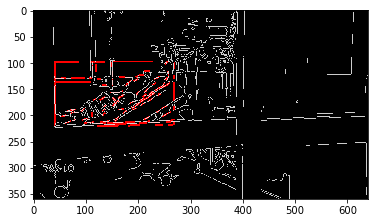

In [25]:
white_output = 'icu-videos/training7-processed.mp4'
clip1 = VideoFileClip("icu-videos/training7.mp4")
white_clip = clip1.fl_image(rcnn_apply_image_withboundingbox) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)